In [1]:
import hail as hl

# example, please use your own temp bucket
hl.init(default_reference='GRCh38',
        tmp_dir='gs://gchau-qc/tmp_dir')  
from hail.utils.java import Env
from hail.utils import hadoop_open
import gwaspy.pca as pca
from hail.plot import output_notebook, show
output_notebook()
import pandas as pd
import numpy as np

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column
import numpy as np
from datetime import date

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


SPARKMONITOR_LISTENER: Started SparkListener for Jupyter Notebook
SPARKMONITOR_LISTENER: Port obtained from environment: 49915
SPARKMONITOR_LISTENER: Application Started: application_1714973709896_0001 ...Start Time: 1714975476704


Running on Apache Spark version 3.3.0
SparkUI available at http://gchau-bge-m.c.genotype-qc-neale-lab.internal:40207
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.117-2a7ef112c342
LOGGING: writing to /home/hail/hail-20240506-0604-0.2.117-2a7ef112c342.log


Loading BokehJS ...

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
class JointCalledSet:
    """
    Represents a joint set of genetic variant calls obtained from exome sequencing (exo)
    and imputation (imp) datasets. Provides methods for loading, merging, and analyzing these datasets.

    Args:
        exo_path (str): Path to the exome variant call file in VCF format.
        imp_path (str): Path to the imputation variant call file in VCF format.
        output_directory (str): Directory where the output files will be saved.
        priority (str, optional): The priority dataset ('exome' or 'imputation'). Defaults to 'exome'.

    Attributes:
        exo (hl.MatrixTable): Hail MatrixTable representing the exome dataset.
        imp (hl.MatrixTable): Hail MatrixTable representing the imputation dataset.
        out_path_prefix (str): Prefix for the output file paths.
        priority (str): The priority dataset ('exome' or 'imputation').
        merged (hl.MatrixTable): Merged dataset with priority given to the specified dataset.
        overlap (hl.MatrixTable): Dataset representing the overlap of variants and samples between exome and imputation datasets.
        _num_exo_sites (int): Number of variants in the exome dataset.
        _num_exo_samples (int): Number of samples in the exome dataset.
        _num_imp_sites (int): Number of variants in the imputation dataset.
        _num_imp_samples (int): Number of samples in the imputation dataset.
        _n_overlap_sites (int): Number of overlapping variants between exome and imputation datasets.
        _n_overlap_samples (int): Number of overlapping samples between exome and imputation datasets.
        _shape (tuple): Cached tuple representing the shape (variants, samples) of the merged dataset.

    Methods:
        load_sets(self, exo_path, imp_path): Loads exome and imputation datasets into Hail tables.
        set_priority(self, new): Sets a new priority for the dataset.
        describe(self): Describes the merged dataset.
        export_table(self, out_type, overwrite=False): Exports the merged dataset in the specified format.
        export_flat(self, lst, fname): Exports a list to a flat file.
        export_samples(self, sample_file_prefix='jc_samples'): Exports the list of matching samples to a file.
        split_multi(self): Splits multi-allelic variants and updates the internal dataset.
        count_multi_split(self): Counts the number of variants and samples after multi-allelic splitting.
        concordance(self, output_name=None): Calculates concordance between exome and imputation datasets.
        calc_overlap(self, output_name=None): Calculates the overlap matrix of variants and samples between datasets.

    Properties:
        shape (tuple): Lazily evaluated property returning the shape (variants, samples) of the merged dataset.
    """
    def __init__(self, 
                 exo_path, 
                 imp_path, 
                 output_directory, 
                 log_outname=f'merging-tool-{date.today().isoformat()}-{np.random.randint(100,999)}.log',
                 priority='exome',
                 keep_all_fields=False,
                 impute_nonsimilar_samples=False):
        self.exo_path, self.imp_path = exo_path, imp_path
        self.load_sets(exo_path, imp_path)
        self.log = ''
        _msg = ''
                
        if output_directory[-1] != '/':
            raise ValueError('Output Directory must be a directory!')
        else:
            self.out_path_prefix = output_directory

        self.log_outpath = f'{self.out_path_prefix}{log_outname}'
        print(f'Logging session at {self.log_outpath}.')

        self.exo = self.exo.annotate_entries(
            GT = hl.vds.lgt_to_gt(self.exo.LGT, self.exo.LA)
        )

        self.priority = priority
        
        if not keep_all_fields:
            # drop these but we might want them later
            fields_to_remove_exo = list(self.exo.entry.dtype.fields)
            fields_to_remove_exo.append('info')
            fields_to_remove_exo.remove('GT')

            fields_to_remove_imp = list(self.imp.entry.dtype.fields)
            fields_to_remove_imp.append('info')
            fields_to_remove_imp.remove('GT')
            self.exo = self.exo.drop(*fields_to_remove_exo)
            self.imp = self.imp.drop(*fields_to_remove_imp)
        
        if impute_nonsimilar_samples:
            samples_in_imp = set(self.imp.s.collect())
            samples_in_exo = set(self.exo.s.collect())
            non_intersecting_samples = samples_in_imp.symmetric_difference(samples_in_exo)

            for sample in non_intersecting_samples:
                self.imp = self.imp.annotate_entries(**{sample: hl.missing(hl.tcall)})

            joined_dataset = self.imp.union_rows(self.exo)

            imputed_gt_value = hl.call(0, 0)
            joined_dataset = joined_dataset.annotate_entries(**{sample: hl.coalesce(joined_dataset[sample], imputed_gt_value) for sample in non_intersecting_samples})

        self._num_exo_sites, self._num_exo_samples = self.exo.count()
        self._num_imp_sites, self._num_imp_samples = self.imp.count()
        
        _msg += f'Loaded {self._num_exo_sites} sites and {self._num_exo_samples} samples from {self.exo_path}.\n'
        _msg += f'Loaded {self._num_imp_sites} sites and {self._num_imp_samples} samples from {self.imp_path}.\n'
        print(_msg)
        
        if self._num_exo_samples != self._num_imp_samples:
            samples_diff = list(set(self.exo.s.collect()) - set(self.imp.s.collect()))
            diff_path = f'{self.out_path_prefix}no_sample_match.txt'
            self.export_flat(samples_diff, diff_path)
            _msg += f'Warning: {len(samples_diff)} have no match! Saving to {diff_path}.\n'
            print(f'Warning: {len(samples_diff)} have no match! Saving to {diff_path}.')
        else:
            _msg += 'Success! All samples matched.\n'
            print('Success! All samples matched.')
                                   
        # takes union of rows (sites), priority on exomes by default.
        _msg += 'Merging...\n'
        print('Merging...')
        
        self.merge()
        
        #self.merged = self.merged.repartition(1000)
        _msg += f'Done merging! Priority has been given to {self.exo_path}.\nTherefore {self.exo_path} variant calls will be preserved and {self.imp_path} \
        will be overwritten.\n'
        print(f'Done merging! Priority has been given to {self.exo_path}.\nTherefore {self.exo_path} variant calls will be preserved and {self.imp_path} will be overwritten.')

        # also calculates overlap matrix: overlap on both variants and samples
        self.calc_overlap(output_name=None)
        
        self.update_required = True
        self.exome_split = None
        self._multi_shape = None
        self.PRIORITIES = {'exome', 'imputation'}
        self.OUT_TYPES = {'vcf', 'PLINK', 'plink', 'hail'}
        self._shape = None
        self.samples = None
        self.sample_conc = None
        self.site_conc = None

        _msg += f'Merged for a total of {self.shape[0]} sites and {self.shape[1]} samples.'
        print(f'Merged for a total of {self.shape[0]} sites and {self.shape[1]} samples.')
        
        self.log += _msg
        
    def load_sets(self, exo_path, imp_path):
        """
        Loads exome and imputation datasets into hail format.
        Args:
            exo_path (str): Path to the exome variant call file in VCF format.
            imp_path (str): Path to the imputation variant call file in VCF format.
        """
        if exo_path[-4:] == '.bgz' or exo_path[-3:] == '.gz':
            self.exo = hl.import_vcf(exo_path, 
                           force_bgz=True,
                           call_fields=['LGT'])
        else:
            self.exo = hl.import_vcf(exo_path, 
                           call_fields=['LGT'])
        
        if imp_path[-4:] == '.bgz' or imp_path[-3:] == '.gz':
            self.imp = hl.import_vcf(imp_path, 
                               force_bgz=True,)
        else:
            self.imp = hl.import_vcf(imp_path)
    
    def set_priority(self, new):
        """
        sets a new priority for the dataset
        Args:
            new (str): New priority ('exome' or 'imputation').
        """
        if not new in self.PRIORITIES:
            raise ValueError(f'New priority must be one of {self.PRIORITIES}.')
        self.priority = new
    
    def describe(self):
        """
        Calls describe on the merged mt.
        """
        self.merged.describe()
        
    def export_table(self, out_type, file_name_prefix='merged', overwrite=False):
        """
        exports the merged dataset in the specified format.
        Args:
            out_type (str): Output format ('vcf', 'PLINK', 'plink', 'hail').
            overwrite (bool, optional): If True, overwrite existing output files.
        """
        if not out_type in self.OUT_TYPES:
            raise ValueError(f'Export type must be in {self.OUT_TYPES}.')
        if out_type == 'hail':
            export_outpath = f'{self.out_path_prefix}{file_name_prefix}.mt'
            self.merged.write(export_outpath)
        elif out_type == 'vcf':
            export_outpath = f'{self.out_path_prefix}{file_name_prefix}.vcf.bgz'
            hl.export_vcf(self.merged, export_outpath)
        else:
            export_outpath = f'{self.out_path_prefix}{file_name_prefix}'
            hl.export_plink(self.merged, export_outpath, ind_id=self.merged.s)
            sites = self.generate_sites_file(export=True)
            
        _msg = f'Exported merged set to {export_outpath} with {self.shape[0]} sites and {self.shape[1]} samples.'
        print(_msg)
        
        self.log += _msg + '\n'
            
    def export_flat(self, itm, fname):
        """
        exports a list or string to a flat file. NOTE: requires GCS connector.
        Args:
            itm (obj): Item to be exported.
            fname (str): File name for the exported list.
        """
        if isinstance(itm, list):
            pd.DataFrame(itm).to_csv(fname, sep='\t', index=False, header=False)
        else:
            with hadoop_open(fname, 'w') as f: 
                f.write(itm)

            
    def export_samples(self, sample_file_prefix='jc_samples'):
        """
        exports the list of matching samples to a file.
        Args:
            sample_file_prefix (str, optional): Prefix for the sample file name.
        """
        if not self.samples: 
            self.samples = self.merged.s.collect()
        sample_out_path = f'{self.out_path_prefix}{sample_file_prefix}.txt'
        self.export_flat(self.samples, sample_out_path)
        
        _msg = f'Matching sample list saved to {sample_out_path}.'
        print(_msg)
        self.log += _msg + '\n'
            
    def split_multi(self):
        """
        splits multi-allelic variants and updates the internal dataset [self.exome_split].
        """
        if not self.exome_split:
            bi = self.exo.filter_rows(hl.len(self.exo.alleles) == 2)
            bi = bi.annotate_rows(a_index=1, was_split=False, old_locus=bi.locus, old_alleles=bi.alleles)
            multi = self.exo.filter_rows(hl.len(self.exo.alleles) > 2)
            split = hl.split_multi(multi)
            split = split.union_rows(bi).drop(*['a_index', 'was_split', 'old_locus', 'old_alleles'])
            self.exome_split = self.merged.union_rows(split)
        else:
            _msg = 'JointCalledSet has already been split!'
            print(_msg)
            self.log += _msg + '\n'
            
        if not self._multi_shape:
            self.count_multi_split()
            
        _msg = f'Before multi-allelic split, exome has {self._num_exo_sites} variants and {self._num_exo_samples} samples.'
        print(_msg)
        self.log += _msg + '\n'
        
        _msg = f'After multi-allelic split, exome has {self._multi_shape[0]} variants and {self._multi_shape[1]} samples.'
        print(_msg)
        self.log += _msg + '\n'
        
    def count_multi_split(self):
        self._multi_shape = self.exome_split.count()
        
    def concordance(self, output_name=None, graph_out=True):
        """
        calculates concordance between exome and imputation datasets.
        Args:
            output_name (str or list, optional): Output file name or list of output file names, ordered by [col, row].
        """
        def parse_global_conc(n_sites, mat):
            total_conc = [x[1:] for x in global_conc[1:]]
            on_diag = sum(total_conc[i][i] for i in range(len(total_conc)))
            total_obs = sum(sum(x) for x in total_conc)
            pct = on_diag / total_obs * 100 if total_obs > 0 else float('nan')
            _msg = f"Overall concordance among the {n_sites} shared bi-allelic sites is {pct:.2f}%."
            print(_msg)
            self.log += _msg + '\n'
        
        def graph_histogram(data, discordance_type):
            if discordance_type not in set(['sample', 'variant']):
                raise ValueError('Please provide either sample or variant discordance.')
            hist, edges = np.histogram(data)
            p = figure(title=f"Distribution of {discordance_type} discordance", 
                       x_axis_label="n_discordant", 
                       y_axis_label="Frequency")
            p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.5)
            show(p)

            
        bi_exo = self.exo.filter_rows(hl.len(self.exo.alleles) == 2)
        bi_imp = self.imp.filter_rows(hl.len(self.imp.alleles) == 2)
        _msg = 'Calculating concordance...\n'
        _msg += f'Filtered {self.exo_path} from {self._num_exo_sites} to {bi_exo.count()[0]} bi-allelic sites.\n'
        _msg += f'Filtered {self.imp_path} from {self._num_imp_sites} to {bi_imp.count()[0]} bi-allelic sites.'
        self.log += _msg + '\n'
        
        global_conc, col_conc, row_conc = hl.concordance(bi_exo, bi_imp)
        _n_bi_sites, _ = bi_exo.semi_join_rows(bi_imp.rows()).count()
        
        _msg = f'{self.exo_path} and {self.imp_path} share {_n_bi_sites} bi-allelic sites.\n  \
        Calculating concordance...'
        print(_msg)
        self.log += _msg + '\n'

        # parse output table to make it more useable
        # subsetting to common alleles, distribution of concordance over sites/ discordance over samples
        parse_global_conc(_n_bi_sites, global_conc)
        
        if output_name:
            if isinstance(output_name, list):
                col_conc_fname = f'{self.out_path_prefix}{output_name[0]}'
                col_conc.export(col_conc_fname)
                row_conc_fname = f'{self.out_path_prefix}{output_name[1]}'
                row_conc.export(row_conc_fname)
                
            elif isinstance(output_name, str):
                col_conc_fname = f'{self.out_path_prefix}{output_name}_sample.tsv'
                col_conc.export(col_conc_fname)
                row_conc_fname = f'{self.out_path_prefix}{output_name}_sites.tsv'
                row_conc.export(row_conc_fname)
                
            else:
                raise ValueError(f'output_name must be either string or list.')
                
        _msg = f'Saved sample and site concordance tables to {col_conc_fname} and {row_conc_fname}.'
        print(_msg)
        self.log += _msg + '\n'
        
        col_conc = pd.read_csv(col_conc_fname, sep='\t', header=0)
        row_conc = pd.read_csv(row_conc_fname, sep='\t', header=0)
        
        graph_histogram(col_conc['n_discordant'], 'sample')
        graph_histogram(row_conc['n_discordant'], 'variant')
        
        self.gc = global_conc
        self.sample_conc = col_conc
        self.site_conc = row_conc

    def remove_discordant(self, which, thresh=None):
        if self.sample_conc is None or self.site_conc is None:
            raise ValueError('Please compute concordance tables first!')
        if not thresh:
            raise ValueError('Please provide a threshold.')
        #         if not path:
        #             raise ValueError('Please provide a path to the discordance output.')
        if which not in set(['sample', 'variant', 'site']):
            raise ValueError('Must be either variant or sample discordance.')
        
        if which == 'sample':
            df = self.sample_conc
        else:
            df = self.site_conc
        filtered = df[df['n_discordant'] > thresh]
        
        if which == 'site' or which == 'variant':
            set_keep = hl.literal(set(list(filtered['locus'].apply(lambda x: hl.parse_locus(x)))))
            _msg = f'Filtering {which} to < {thresh} n_discordant.'
            print(_msg)
            self.log += _msg + '\n'
            self.merged = self.merged.filter_rows(set_keep.contains(self.merged.locus), keep=True)
        else:
            set_keep = hl.literal(set(filtered['s']))
            _msg = f'Filtering {which} to < {thresh} n_discordant.'
            print(_msg)
            self.log += _msg + '\n'
            self.merged = self.merged.filter_cols(set_keep.contains(self.merged.s), keep=True)
        
        
    def calc_overlap(self, output_name=None):
        """
        calculates the overlap matrices of variants and samples between datasets, first filtering to bi-allelic sites
        Args:
            output_name (str, optional): Output file name.
        """
        self.overlap = self.exo.semi_join_rows(self.imp.rows())
        self.overlap = self.overlap.semi_join_cols(self.exo.cols())
        self._n_overlap_sites, self._n_overlap_samples = self.overlap.count()
        print(f'{self._n_overlap_sites} sites and {self._n_overlap_samples} samples are similar between {self.exo_path} and {self.imp_path}.')
        
        if output_name:
            out_name = f'{self.out_path_prefix}{output_name}.txt'
            locs = self.overlap.locus.collect()
            loci = list(map(lambda x: str(x), locs))
            self.export_flat(loci, out_name)
            print(f'{len(loci)} variants overlap between both files, written to {out_name}.')
            
            
    def plot_concordance(self, col_conc_fname):
        self.merged = hl.variant_qc(self.merged)
        self.merged = self.merged.annotate_rows(MAF=hl.min(self.merged.variant_qc.AF))
        
        col_conc = pd.read_csv(col_conc_fname, sep='\t', header=0)
        x = self.merged.MAF.collect()
        y = (np.ones(len(col_conc['n_discordant'].values)) * jc.shape[1] - col_conc['n_discordant'].values) / jc.shape[1]        
        
        #         print(x)
        #         print(y)
        z = np.array(list(sorted(zip(x, y), key=lambda v: v[0]))).T
        
        p = figure(title="Concordance over all chromosomes", 
                   x_axis_label='MAF (%)', 
                   y_axis_label='Sample concordance')
        self.x = x
        self.y = y
    
        p.circle(z[0, :]*100, z[1, :], size=3, alpha=0.5)
        show(p)
        self.maf_plot = p
    

    def generate_sites_file(self, export=False):
        rsids = self.merged.rsid.collect()
        locus = self.merged.locus.collect()
        
        sites = 'MarkerName\tChromosome\tPosition\n'
        for rsid, loc in zip(rsids, locus):
            sites += f'{risd}\t{locus.contig}\t{locus.position}\n'
            
        if export:
            export_outpath = f'{self.out_path_prefix}.sites'
            
        return sites
    
    
    def merge(self):
        def align_mt2_cols_to_mt1(mt1, mt2):
            mt1 = mt1.add_col_index()
            mt2 = mt2.add_col_index()
            new_col_order = mt2.index_cols(mt1.col_key).col_idx.collect()
            return mt2.choose_cols(new_col_order)

        if self.priority == 'exome':
            not_exo = self.imp.anti_join_rows(self.exo.rows())
#             not_exo = align_mt2_cols_to_mt1(not_exo, self.exo)
            self.exo = self.exo.semi_join_cols(not_exo.cols())
            not_exo = align_mt2_cols_to_mt1(self.exo, not_exo)
            self.merged = self.exo.union_rows(not_exo)
        else:
            not_imp = self.exo.anti_join_rows(self.imp.rows())
#             not_imp = align_mt2_cols_to_mt1(not_imp, self.imp)
            self.imp = self.imp.semi_join_cols(not_imp.cols())
            not_imp = align_mt2_cols_to_mt1(self.imp,not_imp)
            self.merged = self.imp.union_rows(not_imp)

    
    def save_log(self):
        """
        Saves log string to logging file.
        """
        self.export_flat(self.log, self.log_outpath)
        
    
    @property
    def shape(self):
        if self._shape is None:
            self._shape = self.merged.count()
        return self._shape

In [8]:
# first, we make a jcs object. note: sample non-matches will be handled upon initialization
jc = JointCalledSet('gs://bge_pilot_dataset/data/scz_blended_wes_wgs_pilot_merged_updated.vcf.bgz', 
                    'gs://bge_pilot_dataset/bge_pilot_dataset.1kg_imputation.vcf.gz', 
                    'gs://gchau-qc/bge_pilot/full_pilot_saved/',
                   )

Logging session at gs://gchau-qc/bge_pilot/full_pilot_saved/merging-tool-2024-04-04-942.log.


Loaded 6541288 sites and 764 samples from gs://bge_pilot_dataset/data/scz_blended_wes_wgs_pilot_merged_updated.vcf.bgz.
Loaded 61715567 sites and 764 samples from gs://bge_pilot_dataset/bge_pilot_dataset.1kg_imputation.vcf.gz.

Success! All samples matched.
Merging...
Done merging! Priority has been given to gs://bge_pilot_dataset/data/scz_blended_wes_wgs_pilot_merged_updated.vcf.bgz.
Therefore gs://bge_pilot_dataset/data/scz_blended_wes_wgs_pilot_merged_updated.vcf.bgz variant calls will be preserved and gs://bge_pilot_dataset/bge_pilot_dataset.1kg_imputation.vcf.gz will be overwritten.


1652915 sites and 764 samples are similar between gs://bge_pilot_dataset/data/scz_blended_wes_wgs_pilot_merged_updated.vcf.bgz and gs://bge_pilot_dataset/bge_pilot_dataset.1kg_imputation.vcf.gz.


Merged for a total of 66603940 sites and 764 samples.


In [ ]:
jc.plot_concordance('gs://gchau-qc/bge_pilot/full_pilot_saved/sites_concordance.tsv')

In [21]:
from bokeh.io import export_png
from bokeh.plotting import figure, output_file, save
output_notebook()


Loading BokehJS ...

In [ ]:
show(jc.maf_plot)

In [34]:
z = np.array(list(sorted(zip(jc.x, jc.y), key=lambda v: v[0])))


In [39]:
p = figure(title="Concordance over all chromosomes", 
           x_axis_label='MAF (%)', 
           y_axis_label='Sample concordance')
p.circle(z[0, :]*100, z[1, :], size=3, alpha=0.5)


GlyphRenderer(id='p2526', ...)

Text(0, 0.5, 'Sample concordance')

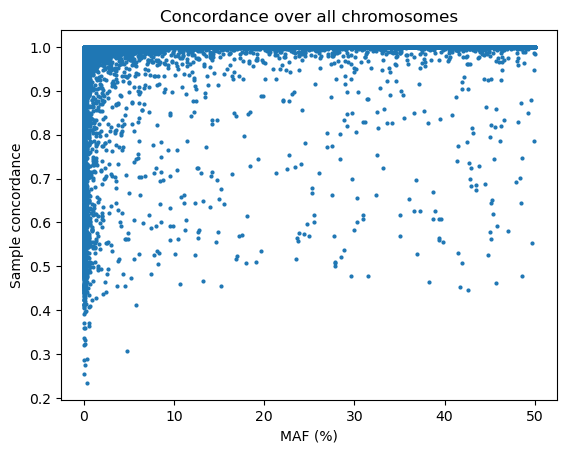

In [51]:
import matplotlib.pyplot as plt
plt.scatter(z[:,0]*100, z[:,1], s=4)
plt.title("Concordance over all chromosomes")
plt.xlabel('MAF (%)')
plt.ylabel('Sample concordance')

In [41]:
# to split-multiallelic sites:
jc.split_multi()


Before multi-allelic split, exome has 6619 variants and 764 samples.
After multi-allelic split, exome has 23552 variants and 764 samples.


In [42]:
# to write out samples with a prefix:
jc.export_samples('test')


Matching sample list saved to gs://gchau-qc/bge_pilot/joint_called_saved/test.txt.


In [81]:
# to write out concordance tables:
jc.concordance(output_name=['samples_condordance.tsv', 'sites_concordance.tsv'])


2024-04-03 20:27:17.396 Hail: INFO: concordance: including 764 shared samples (764 total on left, 764 total on right)
2024-04-03 20:49:40.424 Hail: INFO: concordance: total concordance 95.17%1) / 5]


gs://bge_pilot_dataset/data/scz_blended_wes_wgs_pilot_merged_updated.vcf.bgz and gs://bge_pilot_dataset/bge_pilot_dataset.1kg_imputation.vcf.gz share 1652915 bi-allelic sites.
          Calculating concordance...
Overall concordance among the 1652915 shared bi-allelic sites is 95.17%.


2024-04-03 21:10:13.223 Hail: INFO: Coerced sorted dataset          (4 + 1) / 5]
2024-04-03 21:10:14.569 Hail: INFO: merging 17 files totalling 113.2K...
2024-04-03 21:10:15.826 Hail: INFO: while writing:
    gs://gchau-qc/bge_pilot/full_pilot_saved/samples_condordance.tsv
  merge time: 1.256s
2024-04-03 21:17:06.993 Hail: INFO: merging 225 files totalling 5.6G...1) / 224]
2024-04-03 21:18:34.316 Hail: INFO: while writing:
    gs://gchau-qc/bge_pilot/full_pilot_saved/sites_concordance.tsv
  merge time: 1m27.3s


Saved sample and site concordance tables to gs://gchau-qc/bge_pilot/full_pilot_saved/samples_condordance.tsv and gs://gchau-qc/bge_pilot/full_pilot_saved/sites_concordance.tsv.


In [44]:
# test sample filtering based on concordance
# flag sites/samples to rerun based on discordance
jc.remove_discordant('sample', thresh=100)

Filtering sample to < 100 n_discordant.


In [89]:
# to handle overlaps:
jc.calc_overlap(output_name='overlap_test')


1652915 sites and 764 samples are similar between gs://bge_pilot_dataset/data/scz_blended_wes_wgs_pilot_merged_updated.vcf.bgz and gs://bge_pilot_dataset/bge_pilot_dataset.1kg_imputation.vcf.gz.


1652915 variants overlap between both files, written to gs://gchau-qc/bge_pilot/full_pilot_saved/overlap_test.txt.


In [46]:
# finally, to export ({'hail', 'plink', 'vcf'} supported):
jc.export_table('vcf', file_name_prefix='demo_merge')


2024-03-11 12:07:48.018 Hail: WARN: export_vcf found no row field 'info'. Emitting no INFO fields.
2024-03-11 12:07:53.177 Hail: INFO: merging 3 files totalling 141.3K...+ 1) / 2]
2024-03-11 12:07:53.509 Hail: INFO: while writing:
    gs://gchau-qc/bge_pilot/joint_called_saved/demo_merge.vcf.bgz
  merge time: 331.224ms


Exported merged set to gs://gchau-qc/bge_pilot/joint_called_saved/demo_merge.vcf.bgz with 16602 sites and 764 samples.


In [47]:
# plot MAF vs concordance
jc.plot_concordance('gs://gchau-qc/bge_pilot/joint_called_saved/sites_concordance.tsv')
